In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

# Lenet-5

In [ ]:
kernel_size = 3
stride = 1

lenet_5_model = Sequential()
lenet_5_model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, activation='relu', padding='same', input_shape = (64,64,3)))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(32, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(64, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())

lenet_5_model.add(Flatten())
lenet_5_model.add(Dense(128, activation='relu'))
lenet_5_model.add(Dense(64, activation='relu'))
lenet_5_model.add(Dense(32, activation='relu'))
lenet_5_model.add(Dense(10, activation='softmax'))

lenet_5_model.compile(optimizer=SGD(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Load Dataset

In [ ]:
from DatasetHandler import DatasetHandler

dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
handler = DatasetHandler(dataset_root)

In [ ]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
  print('Class %d -> %s' % (i, cl))

Class 0 -> SeaLake
Class 1 -> Pasture
Class 2 -> River
Class 3 -> PermanentCrop
Class 4 -> Residential
Class 5 -> Industrial
Class 6 -> HerbaceousVegetation
Class 7 -> Highway
Class 8 -> Forest
Class 9 -> AnnualCrop


In [ ]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 26999 Dataset labels: 26999
Dataset sample -> /content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT/Pasture/Pasture_459.jpg 5


In [ ]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5399,)   Y_val shape:  (5399,)


In [10]:
batch_size = 1
epochs = 100

train_gen = handler.cnn_data_loader(train_imgs, train_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)
val_gen = handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = lenet_5_model.fit(train_gen,
                            steps_per_epoch = len(train_labels)//batch_size,
                            epochs = epochs,
                            validation_data = val_gen,
                            validation_steps = len(val_labels)//batch_size,
                            callbacks = [es])

Epoch 1/100
21600/21600 [==============================] - 2242s 104ms/step - loss: 1.7872 - accuracy: 0.3169 - val_loss: 1.7148 - val_accuracy: 0.3671
Epoch 2/100
21600/21600 [==============================] - 864s 40ms/step - loss: 1.6992 - accuracy: 0.3617 - val_loss: 1.6582 - val_accuracy: 0.3971
Epoch 3/100
21600/21600 [==============================] - 379s 18ms/step - loss: 1.6418 - accuracy: 0.3894 - val_loss: 1.6011 - val_accuracy: 0.3941
Epoch 4/100
21600/21600 [==============================] - 207s 10ms/step - loss: 1.5556 - accuracy: 0.4325 - val_loss: 1.4890 - val_accuracy: 0.4751
Epoch 5/100
21600/21600 [==============================] - 139s 6ms/step - loss: 1.4459 - accuracy: 0.4822 - val_loss: 1.3613 - val_accuracy: 0.5157
Epoch 6/100
21600/21600 [==============================] - 118s 5ms/step - loss: 1.3572 - accuracy: 0.5191 - val_loss: 1.2973 - val_accuracy: 0.5355
Epoch 7/100
21600/21600 [==============================] - 116s 5ms/step - loss: 1.2924 - accuracy: 

In [11]:
lenet_5_model.save('/content/drive/MyDrive/QAI4EO/lenet5-v2.h5')

In [23]:
import numpy as np
val_gen = iter(handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10))


predictions = []
targets = []

for ct in range(len(val_images)):
    data, target = next(val_gen)
    output = lenet_5_model.predict(data)
    
    predictions.append(np.argmax(output))
    targets.append(np.argmax(target))
  

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(predictions, targets, normalize='true')

S2
Accuracy: [0.81514085 0.89910979 0.79112754 0.64468864 0.87613843 0.82653061
 0.68217054 0.86030664 0.83295711 0.98113208] mean:  0.8209302242063101
                      precision    recall  f1-score   support

             SeaLake     0.8151    0.8024    0.8087       577
             Pasture     0.8991    0.9727    0.9345       623
               River     0.7911    0.7242    0.7562       591
       PermanentCrop     0.6447    0.6667    0.6555       528
         Residential     0.8761    0.9431    0.9084       510
          Industrial     0.8265    0.8286    0.8276       391
HerbaceousVegetation     0.6822    0.7140    0.6977       493
             Highway     0.8603    0.9283    0.8930       544
              Forest     0.8330    0.7165    0.7704       515
          AnnualCrop     0.9811    0.9123    0.9455       627

            accuracy                         0.8246      5399
           macro avg     0.8209    0.8209    0.8197      5399
        weighted avg     0.8255    0.824

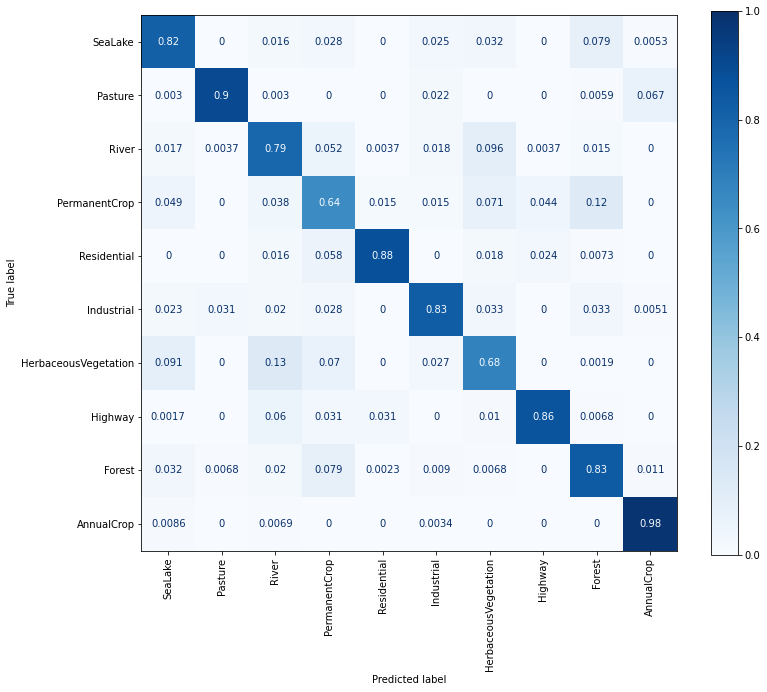

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()